In [1]:
import  os
#set visibile cuda
os.environ["CUDA_VISIBLE_DEVICES"]="8"

In [3]:
import torch
from torch import nn
import numpy as np
import normflows as nf
from IPython import display
from torch.utils.data import TensorDataset


from matplotlib import pyplot as plt

from tqdm import tqdm
# from tools.NF import EnsembleModel,CondEnsembleModel
# from tools.reject_sampling import reject_sample,reject_sample_rf
# from ndtest.ksnd import ks2d2s
#Import ks2sampl
from scipy.stats import ks_2samp

device='cuda'

In [4]:
import logging

logging.basicConfig(format = '%(asctime)s - %(levelname)s -   %(message)s',
                datefmt = '%m/%d/%Y %H:%M:%S',
                level = logging.INFO)

In [9]:

class CondEnsembleModel(nn.Module):
    def __init__(self,models,samples_per_time_limit=10000):
        super().__init__()
        self.models=nn.ModuleList(models)
        self.samples_per_time_limit=samples_per_time_limit

        assert self.samples_per_time_limit%len(self.models)==0,'samples_per_time_limit must be divisible by number of models'
        

    def log_prob(self,x,context):
        log_prob=torch.zeros(x.shape[0],1).to(x.device)
        for model in self.models:
            log_prob+=model.log_prob(x,context)
        return log_prob/len(self.models)
    
    def _sample(self,num_samples,contexts):
        assert num_samples%len(self.models)==0,'num_samples must be divisible by number of models'
        samples=[]
        #cut context into len_model parts
        contexts=torch.chunk(contexts,len(self.models),dim=0)
        for model,context in zip(self.models,contexts):
            with torch.no_grad():
                samples.append(model.sample(num_samples//len(self.models),context)[0])
        return torch.cat(samples,dim=0)
    
    def sample(self,num_samples,contexts,to_numpy=False):
        '''
        to_numpy could realse cuda memory during sampling
        '''
        if num_samples<=self.samples_per_time_limit:
            samples=self._sample(num_samples,contexts)
            if to_numpy:
                samples=samples.detach().cpu().numpy()
            return samples
        else:
            total_samples=[]

            assert num_samples%self.samples_per_time_limit==0,"N_samples must be divisible by sample limit"

            N_chunks=num_samples//self.samples_per_time_limit
            contexts_trunks=torch.chunk(contexts,N_chunks,dim=0)
            for i in range(N_chunks):
                samples=self._sample(self.samples_per_time_limit,contexts_trunks[i])
                if to_numpy:
                    samples=samples.detach().cpu().numpy()
                total_samples.append(samples)
            if to_numpy:
                return np.concatenate(total_samples,axis=0)
            else:
                return torch.cat(total_samples,dim=0)

def get_conditional_ANSF(dim=2,context_size=2,num_layers=32):

    #need to check the meanings of these hyperparameters
    hidden_units = 128
    hidden_layers = 2

    flows = []
    for i in range(num_layers):
        flows += [nf.flows.AutoregressiveRationalQuadraticSpline(dim, hidden_layers, hidden_units, 
                                                                num_context_channels=context_size)]
        flows += [nf.flows.LULinearPermute(dim)]

    # Set base distribution
    q0 = nf.distributions.DiagGaussian(dim, trainable=False)
        
    # Construct flow model
    model = nf.ConditionalNormalizingFlow(q0, flows)

    return model

### Generate Traning Set

In [6]:
import sbibm
from sbibm.metrics import mmd

task = sbibm.get_task("two_moons")  # See sbibm.get_available_tasks() for all tasks
prior = task.get_prior()
simulator = task.get_simulator()

# These objects can then be used for custom inference algorithms, e.g.
# we might want to generate simulations by sampling from prior:
thetas = prior(num_samples=10000)
samples = simulator(thetas)

01/25/2024 18:13:26 - INFO -   Note: detected 80 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
01/25/2024 18:13:26 - INFO -   Note: NumExpr detected 80 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
01/25/2024 18:13:26 - INFO -   NumExpr defaulting to 8 threads.


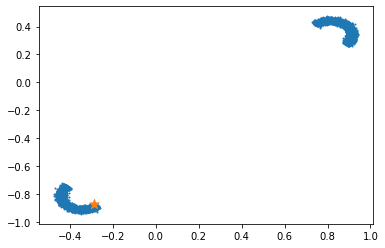

In [8]:
# load /work/dante/scripts/VMEval/dataset/sbibm_tasks/two_moons/files/num_observation_1/observation.csv as array
obs_loc='/work/dante/scripts/VMEval/dataset/sbibm_tasks/two_moons/files/num_observation_2/'

obs=np.loadtxt(os.path.join(obs_loc,'observation.csv'),delimiter=',',skiprows=1)

true_theta=np.loadtxt(os.path.join(obs_loc,'true_parameters.csv'),delimiter=',',skiprows=1)

ref_posterior=np.loadtxt(os.path.join(obs_loc,'reference_posterior_samples.csv'),delimiter=',',skiprows=1)


plt.scatter(ref_posterior[:,0],ref_posterior[:,1],s=1)

plt.scatter(true_theta[0],true_theta[1],marker='*',s=100)

### Set NF model

In [10]:
N_model=1
models=[]
for _ in range(N_model):
    model=get_conditional_ANSF(dim=2,num_layers=16,context_size=2)
    device = torch.device('cuda')
    model = model.to(device)
    models.append(model)

In [11]:
# train_set=TensorDataset(torch.tensor(samples,dtype=torch.float32),torch.tensor(thetas,dtype=torch.float32)) #NLE

#NPE
train_set=TensorDataset(torch.tensor(thetas,dtype=torch.float32),torch.tensor(samples,dtype=torch.float32))

/tmp/ipykernel_2116705/2975654075.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_set=TensorDataset(torch.tensor(thetas,dtype=torch.float32),torch.tensor(samples,dtype=torch.float32))


In [19]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)

### Train NF

In [20]:
losses=[]
for model in models:

    num_epoch = 100
    show_iter = 100

    loss_hist = np.array([])
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)

    batch_trained=0
    for epoch in range(num_epoch):
        
        for batch in tqdm(train_loader):
            optimizer.zero_grad()

            x = batch[0].to(device)
            theta = batch[1].to(device)
            
            # Compute loss
            loss = model.forward_kld(x,theta)
            
            # Do backprop and optimizer step
            if ~(torch.isnan(loss) | torch.isinf(loss)):
                loss.backward()
                optimizer.step()
            
            # Log loss
            loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
            
            # Plot learned distribution
            batch_trained+=1
    
    losses.append(loss_hist)    


100%|██████████| 79/79 [00:09<00:00,  8.06it/s]


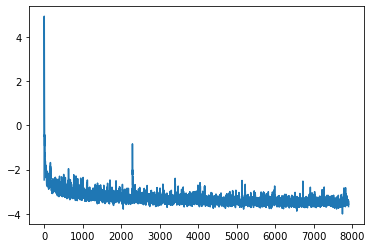

In [21]:
plt.plot(np.array(losses).T)

In [22]:
ens_nf=CondEnsembleModel(models)

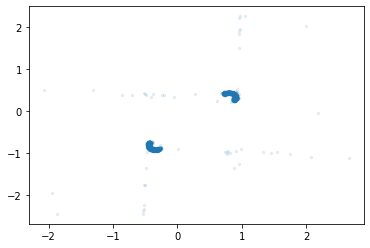

In [23]:
eval_samples=ens_nf.sample(10000,contexts=torch.tensor(np.repeat(obs[None,:],10000,axis=0),
                                                       dtype=torch.float32,device='cuda'),to_numpy=True)

plt.scatter(eval_samples[:,0],eval_samples[:,1],s=5,alpha=0.1)

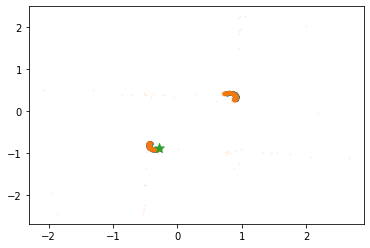

In [24]:

plt.scatter(ref_posterior[:,0],ref_posterior[:,1],s=1)


plt.scatter(eval_samples[:,0],eval_samples[:,1],s=1,alpha=0.1)
plt.scatter(true_theta[0],true_theta[1],marker='*',s=100)

# plt.xlim(-1,-0.5)
# plt.ylim(-0.75,-0.25)

In [25]:
np.save('nf_twomoon_pos.npy',eval_samples)